In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, math
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay


In [2]:
# Camera calibration and distortion parameters (OpenCV) 
fx = 707.0912
fy = 707.0912
cx = 601.8873
cy = 183.1104

#for dataset 00-02
# fx = 718.856
# fy = 718.856
# cx = 607.1928
# cy = 185.2157

cam_mat = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ])
actual_height = 1.7

seq_str = '06'
img_data_dir = '/home/cy/Documents/data/kitti/data_odometry_gray/dataset/sequences/{}/image_0/'.format(seq_str)
gt_file = '/home/cy/Documents/data/kitti/data_odometry_poses/{}.txt'.format(seq_str)

nframes = len([f for f in os.listdir(img_data_dir) if f.endswith(".png")])

seq = int(seq_str)

sample_idx = 200
fn = str(sample_idx).rjust(6, '0')
fnm1 = str(sample_idx+1).rjust(6, '0')
img1 = cv2.imread(os.path.join(img_data_dir,"{}.png".format(fn)), 0)
img2 = cv2.imread(os.path.join(img_data_dir,"{}.png".format(fnm1)), 0)

scale_predict = []
predict_fname = 'tx.txt'

debug_dir = "/home/cy/Documents/data/groundpts_results/"

df_truth = pd.read_csv(gt_file, sep= ' ', header=None)[[3,7,11]]
df_truth.rename(columns={3:'x', 7:'y', 11:'z'}, inplace=True)
df_truth['translation'] = 1.
for i in range(1, len(df_truth)):
    tx = math.pow(df_truth.iloc[i]['x'] - df_truth.iloc[i-1]['x'], 2) + math.pow(df_truth.iloc[i]['y'] - df_truth.iloc[i-1]['y'], 2) + math.pow(df_truth.iloc[i]['z'] - df_truth.iloc[i-1]['z'], 2) 
    df_truth.at[i, 'translation'] = math.sqrt(tx)


ROI = np.array([
    [500, 230], [700, 230], [800, 380], [400, 380]
])
ROI = ROI.reshape((-1, 1, 2))

mask = np.zeros((img1.shape[0], img1.shape[1]), dtype='uint8')
for r in range(mask.shape[0]):
    for c in range(mask.shape[1]):
        p = (c, r)
        if cv2.pointPolygonTest(ROI, p, 0) >= 0:
            mask[r, c] = 255


### feature matching

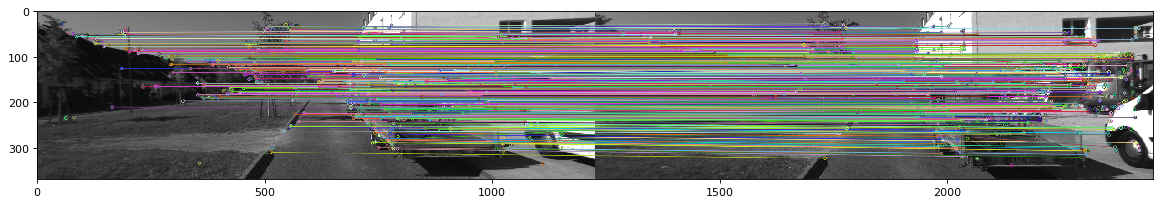

In [46]:
fd = cv2.AKAZE_create(threshold = 0.001)
#fd = cv2.AKAZE_create(threshold = 0.0005)
#fd = cv2.AKAZE_create(threshold = 0.0001)
# fd = cv2.ORB_create(2000)


def get_matches(detector, img1, img2):
    kp1 = detector.detect(img1,  mask = None)
    kp1, desc1 = detector.compute(img1, kp1)

    kp2 = detector.detect(img2,  mask = None)
    kp2, desc2 = detector.compute(img2, kp2)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(desc1, desc2, k=2)
    #matches = bf.match(desc1, desc2)
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
#         if m.distance < 0.8 * n.distance:
            good.append(m)
#     for m in matches:
#         good.append(m)
        
    return kp1, desc1, kp2, desc2, good


#test get matches
kp1, desc1, kp2, desc2, matches = get_matches(fd, img1, img2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2, matches, None,)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img3)
plt.show()

In [47]:
len(kp1)

1278

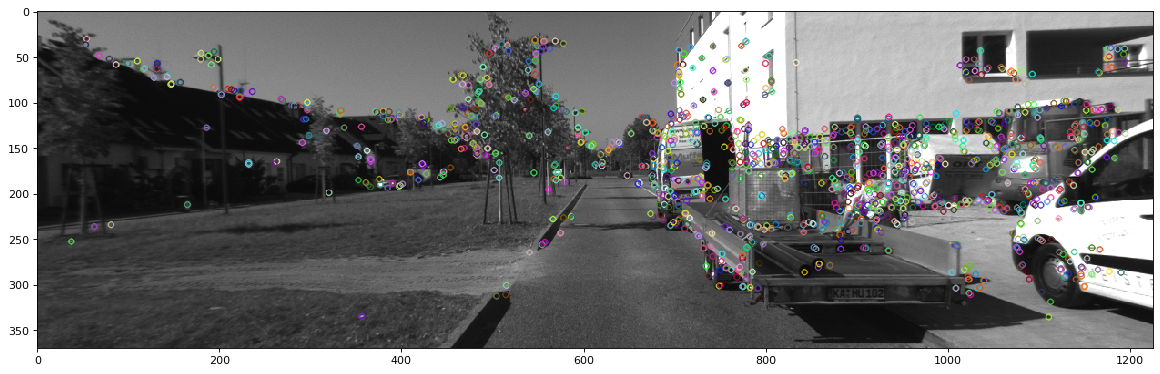

In [48]:
img1kp = cv2.drawKeypoints(img1, kp1, None)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img1kp)
plt.show()

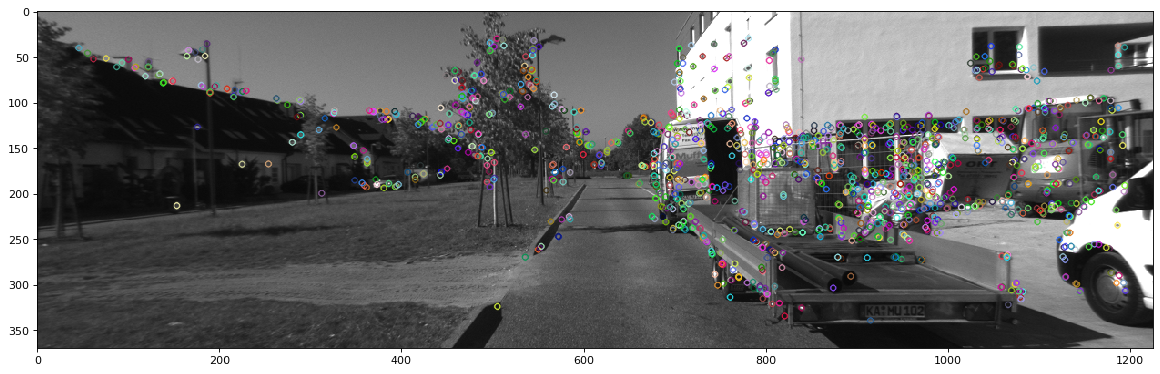

In [49]:
img2kp = cv2.drawKeypoints(img2, kp2, None)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img2kp)
plt.show()

### R, t calculation

In [ ]:
#performs R, T calculation

def getRT(kp1, kp2, matches, K):
    srcPt = []
    dstPt = []
    for p in matches:
        srcPt.append(kp1[p.queryIdx].pt)
        dstPt.append(kp2[p.trainIdx].pt)

    srcPt = np.array(srcPt)
    dstPt = np.array(dstPt)
    E, mask = cv2.findEssentialMat(srcPt, dstPt, K)
    ninliers, R, t, mask = cv2.recoverPose(E, srcPt, dstPt, K, mask = mask)
#     E, mask = cv2.findEssentialMat(dstPt, srcPt, K)
#     ninliers, R, t, mask = cv2.recoverPose(E, dstPt, srcPt, K, mask = mask)
    
    return ninliers, R, t, mask, srcPt, dstPt

ninliers, R, t, mask, mSrcPt, mDstPt = getRT(kp1, kp2, matches, cam_mat)
    
print(mask[mask==0].shape)
print(ninliers)
print(len(matches))
print(R)
print(t)

### Triangulate points to get 3D points

In [ ]:
#lets trianatgulate points to get 3D points
def triangulate_pair(R,t, srcPtFiltered, dstPtFiltered, K):
    R0 = np.identity(3)
    t0 = np.zeros((3,1))
    ext0 = np.hstack((R0, t0))
    P0 = cam_mat.dot(ext0)
    ext1 = np.hstack((R, t))
    P1 = cam_mat.dot(ext1)
    
    X_points_homo = cv2.triangulatePoints(P0, P1, srcPtFiltered.transpose(), dstPtFiltered.transpose())
    X_points2 = X_points_homo/X_points_homo[3, :]
    
    return X_points2[:3, :]


mask2 = mask.flatten()
mask2.dtype = bool
print("before: {}".format(mSrcPt.shape[0]) )
mSrcPt = mSrcPt[mask2, :]
mDstPt = mDstPt[mask2, :]
print("after: {}".format(mSrcPt.shape[0]) )

X = triangulate_pair(R, t, mSrcPt, mDstPt, cam_mat)

#R0 = np.identity(3)
#t0 = np.zeros((3,1))
#ext0 = np.hstack((R0, t0))
#P0 = cam_mat.dot(ext0)
#ext1 = np.hstack((R, t))
#P1 = cam_mat.dot(ext1)

#mask2 = mask.flatten()
#mask2.dtype = bool
#srcPt = srcPt[mask2, :]
#dstPt = dstPt[mask2, :]
#print("size of src pt : {}".format(srcPt.shape))
#X_points_homo = cv2.triangulatePoints(P0, P1, srcPt.transpose(), dstPt.transpose())

#X_points2 = X_points_homo/X_points_homo[3, :]

### Show remaining keypoints after applying filter mask

In [ ]:
imgs = img1.copy()
for p in mSrcPt:
    cv2.circle(imgs, (int(p[0]), int(p[1])), 3, (255, 255, 255) )
    
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(imgs)

In [ ]:
imgd = img2.copy()
for p in mDstPt:
    cv2.circle(imgd, (int(p[0]), int(p[1])), 3, (255, 255, 255) )
    
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(imgd)

### Lets use delaunay triangulation to get triangle lists


In [ ]:
## Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

# Draw a point
def draw_point(img, p, color ) :
    cv2.circle( img, p, 2, color, cv2.cv.CV_FILLED, cv2.CV_AA, 0 )

def get_triangle_lists(points2d):
    pt_int = [[int(x), int(y)] for x,y in points2d]
    try:
        triangulation_sp = Delaunay(pt_int)
    except:
        return []
    return triangulation_sp.simplices
    

img_size = img1.shape
#rect = (0, 0, img_size[1], img_size[0])
#triangulation =  cv2.Subdiv2D(rect)

#for pt in srcPt:
#    x = int(pt[0])
#    y = int(pt[1])
#    if x < 0 or y < 0:
#        print("wrong")
#    triangulation.insert((x,y))
    
#tlist = triangulation.getTriangleList()

color = (240, 240, 240)
#srcPt_int = [[int(x), int(y)] for x,y in srcPt ]
#triangulation_sp = Delaunay(srcPt_int)

show_img = img1.copy()
for id1, id2, id3 in get_triangle_lists(mSrcPt):
    pt1 = ( int(mSrcPt[id1][0]), int(mSrcPt[id1][1]) )
    pt2 = ( int(mSrcPt[id2][0]), int(mSrcPt[id2][1]) )
    pt3 = ( int(mSrcPt[id3][0]), int(mSrcPt[id3][1]) )
    
    cv2.line(show_img, pt1, pt2, color, 1, cv2.LINE_AA, 0)
    cv2.line(show_img, pt2, pt3, color, 1, cv2.LINE_AA, 0)
    cv2.line(show_img, pt3, pt1, color, 1, cv2.LINE_AA, 0)
    
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(show_img)
    

### Calculate known normal

In [ ]:
import math
angle = 4. * math.pi /180.

T_actual_road = np.array([
    [1, 0., 0.],
    [0., math.cos(angle), -math.sin(angle)],
    [0., math.sin(angle), math.cos(angle)]
])

T_road_actual = np.linalg.inv(T_actual_road)

ideal_norm = np.array([ [0.], [1.], [0.] ])
ideal_norm = T_actual_road.dot(ideal_norm)

print("ideal norm: {}".format(ideal_norm))
print("ideal norm length: {}".format(np.linalg.norm(ideal_norm)))

#### Get ground points based on triangle list normal

In [ ]:
def filter_ground_trianglelist(tlist, points3D, gt_normal, srcPt_int, dstPt_int):

#def filter_ground_trianglelist(tlist, points3D, gt_normal, mean_height=-1):
    
    b = np.ones((3, 1), dtype=float)
    nground = 0
    pos_indices = []
    heights = []
    
    pointsRoad = T_road_actual.dot(points3D)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    #bottomLeftCornerOfText = (10,100)
    fontScale              = 0.5
    fontColor              = (255, 0 ,255)
    lineType               = 1
    
    for idx, (id1, id2, id3) in enumerate(tlist):
        X1 = points3D[:, id1]
        X2 = points3D[:, id2]
        X3 = points3D[:, id3]
        
        X1road = pointsRoad[:, id1]
        X2road = pointsRoad[:, id2]
        X3road = pointsRoad[:, id3]
        
        x1 = srcPt_int[id1]
        x2 = srcPt_int[id2]
        x3 = srcPt_int[id3]
        
        xd1 = dstPt_int[id1]
        xd2 = dstPt_int[id2]
        xd3 = dstPt_int[id3]
        
#         print("idx: {}".format(idx))
#         print("x1_12: {} {}".format(x1[0], x1[1]))
#         print("x2_12: {} {}".format(x2[0], x2[1]))
#         print("x3_12: {} {}".format(x3[0], x3[1]))
#         print("============================================")

        X = np.zeros((3,3))
        X[0, :] = X1
        X[1, :] = X2
        X[2, :] = X3
        
        normal = np.linalg.inv(X).dot(b)
        norm = np.linalg.norm(normal)
        height = 1./norm
        
        normal_road = T_road_actual.dot(normal)
        
        angle = math.acos(gt_normal.transpose().dot(normal/norm) ) * 180 / math.pi
        
        if normal[1, 0] > 0 and np.abs(angle) < 5 and X1[1]>0 and X2[1]>0 and X3[1]>0:
       # if np.abs(angle) < 5. and X1[1]>0 and X2[1]>0 and X3[1]>0:
            #if mean_height == -1 or np.abs((height - mean_height) / mean_height) < .2:
                nground += 3
                pos_indices += [id1, id2, id3]
                
                heights.append(X1road[1])
                heights.append(X2road[1])
                heights.append(X3road[1])
                
#                 saveimg = img1.copy()
#                 saveimg = cv2.cvtColor(saveimg, cv2.COLOR_GRAY2BGR)
            
#                 saveimg2 = img2.copy()
#                 saveimg2 = cv2.cvtColor(saveimg2, cv2.COLOR_GRAY2BGR)

#                 with open(os.path.join(debug_dir, "tri{}.txt".format(idx)), 'w') as f:
#                    f.write("{} {} {}\n".format(X1road[0], X1road[1], X1road[2]))
#                    f.write("{} {} {}\n".format(X2road[0], X2road[1], X2road[2]))
#                    f.write("{} {} {}\n".format(X3road[0], X3road[1], X3road[2]))
#                    f.write("{} {} {}\n".format(normal[0], normal[1], normal[2]))
#                    f.write("{}".format(angle))

#                 cv2.circle(saveimg, (int(x1[0]), int(x1[1])), 3, (255, 0, 0) )
#                 cv2.putText(saveimg,'{:.2f},{:.2f},{:.2f} {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(X1road[0], 
#                                                                                      X1road[1], 
#                                                                                      X1road[2],
#                                                                                      x1[0],
#                                                                                      x1[1],
#                                                                                      xd1[0],
#                                                                                      xd1[1]
#                                                                                     ), 
#                     (20, 70), 
#                     font, 
#                     fontScale,
#                     (255, 0, 0),
#                     lineType)
#                 cv2.circle(saveimg, (int(x2[0]), int(x2[1])), 3, (0, 255, 0) )
#                 cv2.putText(saveimg,'{:.2f},{:.2f},{:.2f} {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(X2road[0], 
#                                                                                      X2road[1], 
#                                                                                      X2road[2],                                                                                          x1[0],
#                                                                                      x2[0],
#                                                                                      x2[1],
#                                                                                      xd2[0],
#                                                                                      xd2[1]
#                                                                                     ), 
#                     (20, 50), 
#                     font, 
#                     fontScale,
#                     (0, 255, 0),
#                     lineType)
#                 print("idx: {}".format(idx))
#                 print("x1: {} {}".format(x1[0], x1[1]))
#                 print("x2: {} {}".format(x2[0], x2[1]))
#                 print("x3: {} {}".format(x3[0], x3[1]))
#                 print("xd1: {} {}".format(xd1[0], xd1[1]))
#                 print("xd2: {} {}".format(xd2[0], xd2[1]))
#                 print("xd: {} {}".format(xd3[0], xd3[1]))
#                 print("============================================")
#                 cv2.circle(saveimg, (int(x3[0]), int(x3[1])), 3, (0, 0, 255) )
#                 cv2.putText(saveimg,'{:.2f},{:.2f},{:.2f} {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(X3road[0], 
#                                                                                      X3road[1], 
#                                                                                      X3road[2],
#                                                                                      x3[0],
#                                                                                      x3[1],
#                                                                                      xd3[0],
#                                                                                      xd3[1]                                                                                    
#                                                                                     ), 
#                     (20, 30), 
#                     font, 
#                     fontScale,
#                     (0, 0, 255),
#                     lineType)

#                 cv2.circle(saveimg2, (int(xd1[0]), int(xd1[1])), 3, (255, 0, 0) )
#                 cv2.circle(saveimg2, (int(xd2[0]), int(xd2[1])), 3, (0, 255, 0) )
#                 cv2.circle(saveimg2, (int(xd3[0]), int(xd3[1])), 3, (0, 0, 255) )

#                 cv2.imwrite(os.path.join(debug_dir, "tri{}.png".format(idx)), saveimg)
#                 cv2.imwrite(os.path.join(debug_dir, "tri_dst{}.png".format(idx)), saveimg2)
    
                
#     heights = np.array(heights)
#     median = np.median(heights)
#     std = np.std(heights)
#     pos_indices2 = []
#     for idx in pos_indices:
        #if pointsRoad[:, idx][1] > 1 * std + median or pointsRoad[:, idx][1] <  median - 1 * std:
        #    pass
        #else:
        #    pos_indices2.append(idx)
            
#             saveimg = img1.copy()
#             saveimg = cv2.cvtColor(saveimg, cv2.COLOR_GRAY2BGR)
            
#             saveimg2 = img2.copy()
#             saveimg2 = cv2.cvtColor(saveimg2, cv2.COLOR_GRAY2BGR)

#             with open(os.path.join(debug_dir, "tri{}.txt".format(idx)), 'w') as f:
#                f.write("{} {} {}\n".format(X1[0], X1[1], X1[2]))
#                f.write("{} {} {}\n".format(X2[0], X2[1], X2[2]))
#                f.write("{} {} {}\n".format(X3[0], X3[1], X3[2]))
#                f.write("{} {} {}\n".format(normal[0], normal[1], normal[2]))
#                f.write("{}".format(angle))
                
#             cv2.circle(saveimg, (int(x1[0]), int(x1[1])), 3, (0, 0, 255) )
#             cv2.circle(saveimg, (int(x2[0]), int(x2[1])), 3, (0, 0, 255) )
#             cv2.circle(saveimg, (int(x3[0]), int(x3[1])), 3, (0, 0, 255) )
            
#             cv2.circle(saveimg2, (int(xd1[0]), int(xd1[1])), 3, (0, 0, 255) )
#             cv2.circle(saveimg2, (int(xd2[0]), int(xd2[1])), 3, (0, 0, 255) )
#             cv2.circle(saveimg2, (int(xd3[0]), int(xd3[1])), 3, (0, 0, 255) )

#             cv2.imwrite(os.path.join(debug_dir, "tri{}.png".format(idx)), saveimg)
#             cv2.imwrite(os.path.join(debug_dir, "tri_dst{}.png".format(idx)), saveimg2)
    
    #return pos_indices
    return pos_indices

triangle_lists = get_triangle_lists(mSrcPt)
#gnd_indices = filter_ground_trianglelist(triangle_lists, X, ideal_norm)
gnd_indices = filter_ground_trianglelist(triangle_lists, X, ideal_norm, mSrcPt, mDstPt)
            
img_groundpts_all = img1.copy()
img_groundpts_all = cv2.cvtColor(img_groundpts_all, cv2.COLOR_GRAY2BGR)
                                 
for idx in gnd_indices:
     x = mSrcPt[idx]
     x1 = (int(x[0]), int(x[1]))
     cv2.circle(img_groundpts_all, tuple(x1), 3, (0,255, 255) )
     
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
print("No. of ground points: {}".format(len(gnd_indices)))                    
plt.imshow(img_groundpts_all)                        

### Combine with ROI based method to get more ground points

In [ ]:
ROI = np.array([
    [500, 230], [700, 230], [800, 380], [400, 380]
])
ROI = ROI.reshape((-1, 1, 2))
ROI

In [ ]:
#now combine with ROI based filtering
def filter_ground_ROI(pts2d, ROI):
    pos_indices = []
    for idx, pt in enumerate(pts2d):
        p = ( int(pt[0]), int(pt[1]) )
        if cv2.pointPolygonTest(ROI, p, 0) >= 0:
            pos_indices.append(idx)
            
    return pos_indices
        
img_roi = img1.copy()
img_roi2 = img2.copy()
cv2.polylines(img_roi,[ROI],True,(0,255,255))
cv2.polylines(img_roi2,[ROI],True,(0,255,255))

roi_indices = filter_ground_ROI(mSrcPt, ROI)
roi_only_src = [p.tolist() for idx, p in enumerate(mSrcPt) if idx in roi_indices]
roi_only_dst = [p.tolist() for idx, p in enumerate(mDstPt) if idx in roi_indices]
roi_geo_src = [p.tolist() for idx, p in enumerate(mSrcPt) if idx in roi_indices + gnd_indices]
roi_geo_dst = [p.tolist() for idx, p in enumerate(mDstPt) if idx in roi_indices + gnd_indices]

roi_only_dst = np.array(roi_only_dst)
roi_only_src = np.array(roi_only_src)
roi_geo_src = np.array(roi_geo_src)
roi_geo_dst = np.array(roi_geo_dst)

for idx, pt in enumerate(mSrcPt):
    pt2 = (int(pt[0]), int(pt[1]))
    dst_pt = mDstPt[idx]
    dst_pt2 = (int(dst_pt[0]), int(dst_pt[1]))

    #for display
    if idx in gnd_indices + roi_indices:
        cv2.circle(img_roi, pt2, 3, (255, 255, 255) )
        cv2.circle(img_roi2, dst_pt2, 3, (255, 255, 255) )
    
    #for further processing
    #if cv2.pointPolygonTest(ROI, tuple(pt), 0) >= 0:
    #    roi_only_src.append(pt)
    #    roi_only_dst.append(dst_pt)
    #    roi_geo_src.append(pt)
    #    roi_geo_dst.append(dst_pt)
    #elif idx in pos_indices:
    #    roi_geo_src.append(pt)
    #    roi_geo_dst.append(dst_pt)
        
print("ROI only no. points: {}".format(len(roi_only_src)))
print("ROI + geofitting no. points: {}".format(len(roi_geo_src)))

#roi_only_dst = np.array(roi_only_dst)
#roi_only_src = np.array(roi_only_src)
#roi_geo_src = np.array(roi_geo_src)
#roi_geo_dst = np.array(roi_geo_dst)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img_roi) 

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img_roi2) 


#### Now I have the ground points, calculate normal and height according to Dingfu

In [ ]:
def get_H(src2d, dst2d):
    return cv2.findHomography(src2d, dst2d, method=cv2.RANSAC, ransacReprojThreshold=1.25)

def calulate_nh(R, t, H, K):
    h = np.linalg.inv(K).dot(H).dot(K)
    
    B = np.zeros((9, 1), dtype=float)
    A = np.zeros((9, 4), dtype=float)
    
    B[0, 0] = R[0, 0]
    B[1, 0] = R[0, 1]
    B[2, 0] = R[0, 2]
    B[3, 0] = R[1, 0]
    B[4, 0] = R[1, 1]
    B[5, 0] = R[1, 2]
    B[6, 0] = R[2, 0]
    B[7, 0] = R[2, 1]
    B[8, 0] = R[2, 2]
    B = -B
    
    A[0, 0] = -1 * h[0, 0]
    A[0, 1] =  t[0, 0]
    A[0, 2] = 0
    A[0, 3] = 0
    
    A[1, 0] = -1 * h[0, 1]
    A[1, 1] = 0.
    A[1, 2] = t[0, 0]
    A[1, 3] = 0.
    
    A[2, 0] = -1 * h[0, 2]
    A[2, 1] = 0
    A[2, 2] = 0
    A[2, 3] = t[0, 0]
    
    A[3, 0] = -1 * h[1, 0]
    A[3, 1] = t[1, 0]
    A[3, 2] = 0
    A[3, 3] = 0
    
    A[4, 0] = -1 * h[1, 1]
    A[4, 1] = 0
    A[4, 2] = t[1, 0]
    A[4, 3] = 0
    
    A[5, 0] = -h[1, 2]
    A[5, 1] = 0
    A[5, 2] = 0
    A[5, 3] =t[1, 0]
    
    A[6, 0] = -1 * h[2, 0]
    A[6, 1] = t[2, 0]
    A[6, 2] = 0
    A[6, 3] = 0
    
    A[7, 0] = -1 * h[2, 1]
    A[7, 1] = 0
    A[7, 2] = t[2, 0]
    A[7, 3] = 0
    
    A[8, 0] = -1 * h[2, 2]
    A[8, 1] = 0
    A[8, 2] = 0
    A[8, 3] = t[2, 0]
    
    x, residuals, rank, s = np.linalg.lstsq(A, B)
    x = x[1:, :]
    h = 1. / np.linalg.norm(x)
    x_unit = x / np.linalg.norm(x)
    #print("residuals: {}".format(residuals))
    return x_unit, h, x

### Compare results with only using ROI and ROI+geometric constraints

In [ ]:
if len(roi_only_src) >= 4:
    homo_roi_only, status_roi = get_H(roi_only_src, roi_only_dst)
else:
    homo_roi_only = None

if len(roi_geo_src) >= 4:
    homo_roi_geo, status_roi_geo = get_H(roi_geo_src, roi_geo_dst)
else:
    homo_roi_geo = None
    
if homo_roi_only is not None:
    n_roi, height_roi, n_not_unit = calulate_nh(R, t, homo_roi_only, cam_mat)
    print(n_roi)
    print(repr(n_not_unit) )
    print(math.acos(n_roi.transpose().dot(ideal_norm)) * 180. / math.pi)
    print("scale using roi: {:.3f}".format(actual_height/height_roi))
else: 
    print("homo roi not found!")

if homo_roi_geo is not None:
    n_roi_geo, height_roi_geo, n_roi_geo_notunit = calulate_nh(R, t, homo_roi_geo, cam_mat)
    print(n_roi_geo)
    print(repr(n_roi_geo_notunit))
    print(math.acos(n_roi_geo.transpose().dot(ideal_norm)) * 180. / math.pi)
    print("scale using roi+geo constraints: {:.3f}".format(actual_height/height_roi_geo))

print("ground truth scale: {}".format(df_truth.at[sample_idx+1, 'translation']))

print("R:")
print(repr(R))
print("T:")
print(repr(t))

In [ ]:
df_truth.head(20)

In [ ]:
def runall():
    results = []
    hbuffer = []
    buffer_size = 12
    for i in range(nframes-1):
        print("processing frame {}".format(i))
        cur_img = cv2.imread(os.path.join(img_data_dir, "{}.png".format(str(i).rjust(6, '0'))), 0)
        next_img = cv2.imread(os.path.join(img_data_dir, "{}.png".format(str(i+1).rjust(6, '0'))), 0)
        
        cur_kp, desc1, next_kp, desc2, matches = get_matches(fd, cur_img, next_img)
        ninliers, R, t, mask, mSrcPt, mDstPt = getRT(cur_kp, next_kp, matches, cam_mat)
        
        mask2 = mask.flatten()
        mask2.dtype = bool
        mSrcPt = mSrcPt[mask2, :]
        mDstPt = mDstPt[mask2, :]
        
        if len(mSrcPt) >= 3:
            X = triangulate_pair(R, t, mSrcPt, mDstPt, cam_mat)
            triangle_lists = get_triangle_lists(mSrcPt)
            #if len(hbuffer) >= buffer_size:
            #    gnd_indices = filter_ground_trianglelist(triangle_lists, X, ideal_norm, np.array(hbuffer).mean())
            #else:
            gnd_indices = filter_ground_trianglelist(triangle_lists, X, ideal_norm, mSrcPt, mDstPt)
        else:
            gnd_indices = []
        
        roi_indices = filter_ground_ROI(mSrcPt, ROI)
        roi_only_src = [p.tolist() for idx, p in enumerate(mSrcPt) if idx in roi_indices]
        roi_only_dst = [p.tolist() for idx, p in enumerate(mDstPt) if idx in roi_indices]
        roi_geo_src = [p.tolist() for idx, p in enumerate(mSrcPt) if idx in roi_indices + gnd_indices]
        roi_geo_dst = [p.tolist() for idx, p in enumerate(mDstPt) if idx in roi_indices + gnd_indices]

        roi_only_dst = np.array(roi_only_dst)
        roi_only_src = np.array(roi_only_src)
        roi_geo_src = np.array(roi_geo_src)
        roi_geo_dst = np.array(roi_geo_dst)
        
        if len(roi_only_src) > 4:
            homo_roi_only, status_roi = get_H(roi_only_src, roi_only_dst)
        else:
            homo_roi_only = None
        
        if len(roi_geo_src) > 4:
            homo_roi_geo, status_roi_geo = get_H(roi_geo_src, roi_geo_dst)
        else:
            homo_roi_geo = None
        
        if homo_roi_only is not None:
            n_roi, height_roi, n_notunit_roi = calulate_nh(R, t, homo_roi_only, cam_mat)
            scale_roi = actual_height/height_roi
            angle_roi = math.acos(n_roi.transpose().dot(ideal_norm)) * 180. / math.pi
        else:
            scale_roi = 0
            angle_roi = 0
            print("homo for roi not found!")
        
        if homo_roi_geo is not None:
            n_roi_geo, height_roi_geo, n_notunit_roi_geo = calulate_nh(R, t, homo_roi_geo, cam_mat)
            scale_roi_geo = actual_height/height_roi_geo
            angle_roi_geo = math.acos(n_roi_geo.transpose().dot(ideal_norm)) * 180. / math.pi
        else:
            scale_roi_geo = 0.
            angle_roi_geo = 0.
            print("homo for roi+geo not found!")

        results.append([scale_roi, angle_roi, scale_roi_geo, angle_roi_geo ])
        #if len(hbuffer) >= buffer_size:
        #    hbuffer = hbuffer[1:]
        #hbuffer.append(height_roi_geo)
        
        if nframes % 50 == 0:
            print("Processed {}".format(nframes))
    return results 

results = runall()

In [ ]:
def f(w):                        
    def g(x):
        return (w*x).sum()/w.sum()
    return g
    

results2 = np.array(results) 

weights = np.array([.1, .2, .4, 0.6, 0.8, 1.])

df = pd.DataFrame({'scale_roi': results2[:,0], 
                   'angle_roi': results2[:,1], 
                   'scale_roi_geo': results2[:,2], 
                   'angle_roi_geo': results2[:,3],
                    'frame': np.arange(0, len(results))
                  })
df.to_csv("results-seq{}.csv".format(seq), index=False)

# df = pd.read_csv("results-seq{}.csv".format(seq))


df['avg_scale_roi_geo'] = df['scale_roi_geo'].rolling(window=6).mean()
#df['avg_scale_roi_geo'] = df['scale_roi_geo'].rolling(window=6).apply(f(weights))

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.gca()
df_truth['translation'].plot(ax=ax, label='Ground truth')

df_filtered = df[df.angle_roi_geo < 6]
df_filtered['avg_scale_roi_geo'] = df_filtered['scale_roi_geo'].rolling(window=6).apply(f(weights))

#df.plot.scatter(x='frame', y='scale_roi', c='r', ax=ax, label='Zhou', alpha=.25)
#df.plot.scatter(x='frame', y='scale_roi_geo', c='g', ax=ax, label='Wang+Zhou', alpha=.25)
#df[df.angle_roi_geo < 15].plot(ax=ax, label='Wang+Zhou mean filter', y='avg_scale_roi_geo', x='frame', c='r', alpha=0.5)
df_filtered['avg_scale_roi_geo'].plot(ax=ax, label='Wang+Zhou WMA angle<5.5', c='g', alpha=0.5)
df['avg_scale_roi_geo'].plot(ax=ax, label='Wang+Zhou mean filter', c='y', alpha=0.5)

plt.grid()
plt.ylim(0, 2.)
plt.xticks(np.arange(0, df.shape[0], 100))
plt.yticks(np.arange(0, 2, 0.1))
plt.legend(loc='upper left')
plt.title("scale estimation for roi only vs roi+geo seq6")
plt.savefig('georoi_vs_roi_seq{}_wma_filter_angle5.5.png'.format(seq))
plt.show()

#save scatterplot
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.gca()
df_truth['translation'].plot(ax=ax, label='Ground truth')
df.plot.scatter(x='frame', y='scale_roi', c='r', ax=ax, label='Zhou', alpha=.25)
df.plot.scatter(x='frame', y='scale_roi_geo', c='g', ax=ax, label='Wang+Zhou', alpha=.25)

plt.grid()
plt.ylim(0, 2.)
plt.xticks(np.arange(0, df.shape[0], 100))
plt.yticks(np.arange(0, 2, 0.1))
plt.legend(loc='upper left')
plt.title("Per-frame scale estimation for roi only vs roi+geo seq{}".format(seq))
plt.savefig("georoi_vs_roi_seq{}_scatter.png".format(seq))

In [ ]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.gca()
df.plot.scatter(x='frame', y='angle_roi_geo', ax=ax)
plt.show()

In [ ]:
df_bad = df[df.angle_roi_geo > 6]


fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.grid()
plt.xticks(np.arange(0, df.shape[0], 100))
df_truth['translation'].plot(ax=ax, label='Ground truth')

df_bad.plot.scatter(x='frame', y='scale_roi_geo', c='g', ax=ax, label='Wang+Zhou', alpha=.25)
plt.show()

In [ ]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.grid()
plt.xticks(np.arange(0, df.shape[0], 100))
df_filtered['diff'] = df_filtered.frame.diff()
df_filtered.plot(x='frame', y='diff', ax=ax)
plt.show()


In [ ]:
df_filtered[df_filtered['diff'] == df_filtered['diff'].max()]